## 3 Classifier training

Обучение моделек и развлечение

In [1]:
import numpy as np
import pandas as pd
from model import predict # Функция, позволяет получить предсказание нейронки.
from check_budget import check_budget # функция проверки бюджета. Проверяйте допустимость решения до сабмита
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

bins_path = "nn_bins.pickle" # путь до файла с бинами после тренировки модели (nn_bins.pickle)
model_path = "nn_weights.ckpt" # путь до файла с весами нейронной сети (nn_weights.ckpt)
quantiles_path = "quantiles.json" # путь до файла с квантилями для таргета (quantiles.pickle)

output_path = "naive_submission.csv" # куда сохранить атакованные транзакции
transactions_path = "../sample_submission.csv"    # путь до файла с транзакциями, которые атакуются

train_data_path = "../transactions_finetune.csv" # X - train data
train_target_path = "../target_finetune.csv" # y - true target

In [2]:
df_transactions = pd.read_csv(train_data_path,
                              parse_dates=["transaction_dttm"],
                              dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float}).assign(
    hour=lambda x: x.transaction_dttm.dt.hour,
    day=lambda x: x.transaction_dttm.dt.dayofweek,
    month=lambda x: x.transaction_dttm.dt.month,
    number_day=lambda x: x.transaction_dttm.dt.day)

In [3]:
df_transactions.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,hour,day,month,number_day
0,69,5541,48,-342.89792,2021-03-05 02:52:36,2,4,3,5
1,69,5533,48,-1251.88120,2021-03-05 09:43:28,9,4,3,5
2,69,5331,48,-87.30924,2021-03-05 11:17:23,11,4,3,5
3,69,5921,48,-1822.17700,2021-03-05 13:41:03,13,4,3,5
4,69,5311,48,-427.12363,2021-03-05 19:14:23,19,4,3,5


In [4]:
id_list = df_transactions.user_id.unique()

In [5]:
df_transactions.loc[df_transactions.user_id == id_list[5]]['transaction_amt']

1500    -586.027470
1501     -50.992100
1502   -3318.621800
1503    -582.319640
1504    -461.845340
           ...     
1795    -104.104385
1796    -161.041020
1797    -264.240600
1798    -956.717700
1799   -1349.225600
Name: transaction_amt, Length: 300, dtype: float64

In [6]:
# посмотрим итоговую сумму по транзакциям для каждого юзера
cumsum_list = np.array([])
for i in id_list:
    cumsum_list = np.append(cumsum_list, df_transactions.loc[df_transactions.user_id == i]['transaction_amt'].cumsum().values[-1])

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([-18351825.62893598, -18348705.22605459, -18345584.82317321, ...,
          3734385.96552122,   3737506.36840261,   3740626.771284  ]),
 <BarContainer object of 7080 artists>)

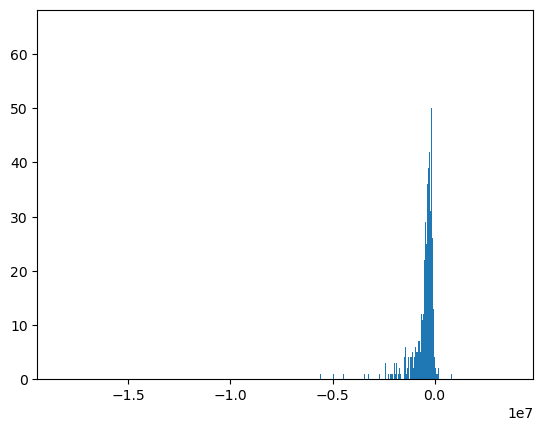

In [7]:
plt.hist(cumsum_list, bins=cumsum_list.shape[0])

In [8]:
df = df_transactions.copy()

In [9]:
df

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,hour,day,month,number_day
0,69,5541,48,-342.89792,2021-03-05 02:52:36,2,4,3,5
1,69,5533,48,-1251.88120,2021-03-05 09:43:28,9,4,3,5
2,69,5331,48,-87.30924,2021-03-05 11:17:23,11,4,3,5
3,69,5921,48,-1822.17700,2021-03-05 13:41:03,13,4,3,5
4,69,5311,48,-427.12363,2021-03-05 19:14:23,19,4,3,5
...,...,...,...,...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09,17,1,5,11
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52,11,3,5,13
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42,11,3,5,13
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44,14,3,5,13


In [10]:
# накапливаемая сумма для транзакций каждого клиента
cumsum = pd.Series()
for i in id_list:
    cumsum = pd.concat([cumsum, df_transactions.loc[df_transactions.user_id == i]['transaction_amt'].cumsum()])
    cumsum.name = 'cumsum'
df = df.join(cumsum)

C:\Users\zekat\AppData\Local\Temp\ipykernel_14520\2653872874.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cumsum = pd.Series()


In [11]:
df

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,hour,day,month,number_day,cumsum
0,69,5541,48,-342.89792,2021-03-05 02:52:36,2,4,3,5,-342.897920
1,69,5533,48,-1251.88120,2021-03-05 09:43:28,9,4,3,5,-1594.779120
2,69,5331,48,-87.30924,2021-03-05 11:17:23,11,4,3,5,-1682.088360
3,69,5921,48,-1822.17700,2021-03-05 13:41:03,13,4,3,5,-3504.265360
4,69,5311,48,-427.12363,2021-03-05 19:14:23,19,4,3,5,-3931.388990
...,...,...,...,...,...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09,17,1,5,11,-361135.468071
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52,11,3,5,13,-361198.720621
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42,11,3,5,13,-361238.767711
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44,14,3,5,13,-361833.546211


In [12]:
target = pd.read_csv(train_target_path)

In [13]:
data = df.merge(target, how='left', on='user_id')

In [14]:
data

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,hour,day,month,number_day,cumsum,target
0,69,5541,48,-342.89792,2021-03-05 02:52:36,2,4,3,5,-342.897920,0
1,69,5533,48,-1251.88120,2021-03-05 09:43:28,9,4,3,5,-1594.779120,0
2,69,5331,48,-87.30924,2021-03-05 11:17:23,11,4,3,5,-1682.088360,0
3,69,5921,48,-1822.17700,2021-03-05 13:41:03,13,4,3,5,-3504.265360,0
4,69,5311,48,-427.12363,2021-03-05 19:14:23,19,4,3,5,-3931.388990,0
...,...,...,...,...,...,...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09,17,1,5,11,-361135.468071,0
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52,11,3,5,13,-361198.720621,0
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42,11,3,5,13,-361238.767711,0
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44,14,3,5,13,-361833.546211,0


In [15]:
X = data[['user_id', 'mcc_code', 'currency_rk', 'transaction_amt',
          'hour', 'day', 'month', 'number_day', 'cumsum']]
y = data[['target']]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, stratify=y, random_state=1) # shuffle=True

In [17]:
y_train.values.ravel()

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [18]:
# градиентный бустинг
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_gbclf = make_pipeline(StandardScaler(),
                           GradientBoostingClassifier(loss='log_loss', n_estimators=10, learning_rate=0.1,
                                                      max_depth=15, random_state=0, verbose=1)
                          )
pipe_gbclf.fit(X_train, y_train.values.ravel())
print('acc: ', pipe_gbclf.score(X_test, y_test))

      Iter       Train Loss   Remaining Time 
         1           0.2819            3.15m
         2           0.2580            2.83m
         3           0.2207            2.54m
         4           0.1963            2.22m
         5           0.1692            1.90m
         6           0.1659            1.52m
         7           0.1589            1.15m
         8           0.1480           47.03s
         9           0.1458           23.58s
        10           0.1360            0.00s
acc:  0.9725


In [19]:
# roc auc score для теста (валидации)
roc_auc_score(y_test, pipe_gbclf.predict_proba(X_test)[:, 1])

0.9849991940271361

In [20]:
# обработка данных для сабмита
def feature_add_handler(data_path):
    X_df = pd.read_csv(data_path,
                       parse_dates=["transaction_dttm"],
                       dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float}).assign(
        hour=lambda x: x.transaction_dttm.dt.hour,
        day=lambda x: x.transaction_dttm.dt.dayofweek,
        month=lambda x: x.transaction_dttm.dt.month,
        number_day=lambda x: x.transaction_dttm.dt.day)

    # накапливаемая сумма для транзакций каждого клиента
    cumsum = pd.Series()
    id_list = X_df.user_id.unique()
    for i in id_list:
        cumsum = pd.concat([cumsum, X_df.loc[X_df.user_id == i]['transaction_amt'].cumsum()])
        cumsum.name = 'cumsum'
    X_df = X_df.join(cumsum)
    X_df = X_df[['user_id', 'mcc_code', 'currency_rk', 'transaction_amt',
                 'hour', 'day', 'month', 'number_day', 'cumsum']]
    return X_df

In [21]:
X_df = feature_add_handler(transactions_path)

C:\Users\zekat\AppData\Local\Temp\ipykernel_14520\1202302041.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cumsum = pd.Series()


In [22]:
threshold = pd.read_csv(train_target_path).target.mean()
threshold

0.037005649717514126

In [23]:
y_df = [0 if x <= threshold else 1 for x in pipe_gbclf.predict_proba(X_df)[:, 1]]

In [24]:
# roc auc score для сабмита
roc_auc_score(y_df, pipe_gbclf.predict_proba(X_df)[:, 1])

1.0

///////////////////////

In [25]:
X_attac = feature_add_handler('first_attack.csv')

C:\Users\zekat\AppData\Local\Temp\ipykernel_14520\1202302041.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cumsum = pd.Series()


In [26]:
# roc auc score для наивной атаки
roc_auc_score(y_df, pipe_gbclf.predict_proba(X_attac)[:, 1])

0.9667929274424091

//////////////////////

In [27]:
# соотношение классов
(y_train.value_counts()/y_train.shape[0])

target
0         0.962994
1         0.037006
dtype: float64

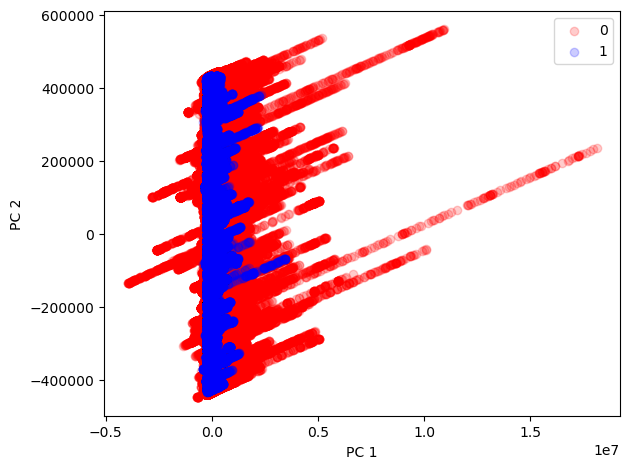

In [30]:
# PCA визуализация для данных
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
y_train_pca = y_train.values.ravel()

colors = ['r', 'b']
# markers = ['s', 'x']

for l, c in zip(np.unique(y_train_pca), colors):
    plt.scatter(X_train_pca[y_train_pca == l, 0],
                X_train_pca[y_train_pca == l, 1],
                c=c, label=l, alpha=0.2)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
X_train, X_valid, y_train, y_valid =\
    train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=1) # shuffle=True

In [32]:
from catboost import CatBoostClassifier

params = {'learning_rate': 0.4,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          # 'n_estimators': 1700,
          'l2_leaf_reg': 2.5,
          'max_depth': 3,
          # 'verbose': 100,
          'early_stopping_rounds': 200,
          'verbose': 200,
          'task_type': 'GPU',
          'random_seed': 123}

cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(X_train, y_train.values.ravel(),
          eval_set=(X_valid, y_valid.values.ravel()))

# grid_search
# model = CatBoostClassifier(verbose=False, task_type='GPU')

# grid = {'learning_rate': [1, 0.6, 0.3, 0.1],
#         'n_estimators': [100, 500, 1000],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}

# grid_search_result = model.grid_search(grid,
#                                        X=X_train,
#                                        y=y_train.values.ravel(),
#                                        shuffle=False,
#                                        partition_random_seed=0)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5506444	best: 0.5506444 (0)	total: 16.8ms	remaining: 16.8s
200:	test: 0.7666395	best: 0.7666395 (200)	total: 3.06s	remaining: 12.2s
400:	test: 0.7944735	best: 0.7944755 (399)	total: 6.21s	remaining: 9.27s
600:	test: 0.8098115	best: 0.8098115 (600)	total: 9.25s	remaining: 6.14s
800:	test: 0.8221509	best: 0.8221509 (800)	total: 12.3s	remaining: 3.05s
999:	test: 0.8294068	best: 0.8294114 (998)	total: 15.4s	remaining: 0us
bestTest = 0.829411447
bestIteration = 998
Shrink model to first 999 iterations.


In [33]:
# roc auc score для сабмита
roc_auc_score(y_df, cbc_2.predict_proba(X_df)[:, 1])

0.7132994038439315

In [34]:
# roc auc score для наивной атаки
roc_auc_score(y_df, cbc_2.predict_proba(X_attac)[:, 1])

0.6770752130327106

In [77]:
# oversampling
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

ros = RandomOverSampler(random_state=0)
smote = SMOTE(random_state=0)
adasyn = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [78]:
# соотношение классов
(y_resampled.value_counts()/y_resampled.shape[0])

target
0         0.5
1         0.5
dtype: float64

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
    train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=1) # shuffle=True

X_train, X_valid, y_train, y_valid =\
    train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=1) # shuffle=True

In [112]:
params = {'learning_rate': 0.32,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          # 'n_estimators': 1700,
          'l2_leaf_reg': 7.5,
          'max_depth': 5,
          # 'verbose': 100,
          'early_stopping_rounds': 200,
          'verbose': 200,
          'task_type': 'GPU',
          'random_seed': 123}

cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(X_train, y_train.values.ravel(),
          eval_set=(X_valid, y_valid.values.ravel()))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5571107	best: 0.5571107 (0)	total: 39.4ms	remaining: 39.4s
200:	test: 0.8448652	best: 0.8448652 (200)	total: 6.18s	remaining: 24.6s
400:	test: 0.8842274	best: 0.8842274 (400)	total: 12.4s	remaining: 18.6s
600:	test: 0.9036157	best: 0.9036157 (600)	total: 18.4s	remaining: 12.2s
800:	test: 0.9171753	best: 0.9171753 (800)	total: 24.7s	remaining: 6.14s
999:	test: 0.9269794	best: 0.9269794 (999)	total: 31s	remaining: 0us
bestTest = 0.9269794226
bestIteration = 999


In [113]:
roc_auc_score(y_test, cbc_2.predict_proba(X_test)[:, 1])

0.9275680561179815

In [114]:
# roc auc score для сабмита
roc_auc_score(y_df, cbc_2.predict_proba(X_df)[:, 1])

0.6814568804643739

In [115]:
# roc auc score для наивной атаки
roc_auc_score(y_df, cbc_2.predict_proba(X_attac)[:, 1])

0.6395766379112693

In [98]:
result = predict(transactions_path, bins_path, model_path, random_seed=1)
result.head()

Global seed set to 1


,user_id,target
0,66,0.020127
1,213,0.029878
2,345,0.160881
3,569,0.079511
4,573,0.017896


In [99]:
result['target_true'] = result.target.apply(lambda x: 0 if x <= threshold else 1)
result

,user_id,target,target_true
0,66,0.020127,0
1,213,0.029878,0
2,345,0.160881,1
3,569,0.079511,1
4,573,0.017896,0
...,...,...,...
4195,868183,0.022651,0
4196,868407,0.036789,0
4197,868573,0.023594,0
4198,868694,0.050012,1


In [102]:
result_attac = predict('first_attack.csv', bins_path, model_path, random_seed=1)
result_attac

Global seed set to 1


,user_id,target
0,66,0.017652
1,213,0.027609
2,345,0.161562
3,569,0.070948
4,573,0.016707
...,...,...
4195,868183,0.020343
4196,868407,0.038560
4197,868573,0.023573
4198,868694,0.046347


In [103]:
roc_auc_score(result['target_true'], result_attac['target'])

0.9980974459450453